In [1]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import itertools
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import sys

sys.path.insert(0, './src')

from data import Dataset
from kernels import HMC_our, HMC_vanilla, Reverse_kernel
from models import Gen_network, Inf_network, Inf_network_simple, Gen_network_simple
from target import NN_bernoulli, GMM_target, NN_Gaussian
from utils import plot_digit_samples, get_samples
from args import get_args

In [2]:
torchType = torch.float32

In [3]:
def set_seeds(rand_seed):
    torch.cuda.manual_seed_all(rand_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)

seed = 1 # 1337 #
set_seeds(seed)

In [4]:
args = get_args()

args.data = "toy_data"
args.z_dim = 2
args.data_dim = 2
args.data_distrib = GMM_target(args, args.device)

In [5]:
if args.data == 'toy_data':
    encoder = Inf_network_simple(kwargs=args).to(args.device)
    target = NN_Gaussian(kwargs=args, model=Gen_network_simple(args.z_dim, args), device=args.device).to(args.device)   
else:
    encoder = Inf_network(kwargs=args).to(args.device)
    target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

if args.learnable_reverse:
    reverse_kernel = Reverse_kernel(kwargs=args).to(args.device)
    reverse_params = reverse_kernel.parameters()
else:
    reverse_params = list([])

if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
    
for p in transitions.parameters():
    p.requires_grad_(False)

params = [encoder.parameters(), target.parameters(), transitions.parameters(), reverse_params]
optimizer = torch.optim.Adam(params=itertools.chain(*params), lr=args.learning_rate)

In [6]:
dataset = Dataset(args, device=args.device)

In [7]:
random_code = args.std_normal.sample((64, args.z_dim))

In [8]:
print_info_ = 20

torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)


def compute_loss(z_new, p_new, u, p_old, x, sum_log_alpha, sum_log_jac, sum_log_sigma, mu=None, all_directions=None):
    log_p = target.get_logdensity(z=z_new, x=x) + args.std_normal.log_prob(p_new).sum(1)
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=z_new, mu=mu.detach(), a=all_directions)
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma + sum_log_alpha
    else:
        log_r = 0 #-args.K * torch_log_2
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma # + sum_log_alpha
    
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full, grad_elbo
  
# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        plt.close()
        cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
        optimizer.zero_grad()

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        p_old = args.std_normal.sample(mu.shape)

        sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        sum_log_sigma = torch.sum(torch.log(sigma), 1)
        p = p_old
        if args.learnable_reverse:
            all_directions = torch.tensor([], device=args.device)
        else:
            all_directions = None
        for k in range(args.K):
            # sample alpha - transition probabilities 
            if args.amortize:
                z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_train,
                                                    p_old=p, k=cond_vectors[k], target_distr=target)
            else:
                z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_train,
                                                                    p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
            if ep  % print_info_ == 0 and b_num % (100 * print_info_) == 0:
                print('On batch number {}/{} and on k = {} we have for  0: {} and for +1: {}'.format(b_num + 1,
                                                                        dataset.train.shape[0] // args['train_batch_size'],
                                                                           k + 1,
                                                    (directions==0.).to(float).mean(),
                                                                    (directions==1.).to(float).mean()))
                if args.amortize:
                    print('Stepsize {}'.format(np.exp(transitions.gamma.cpu().detach().item())))
                    print('Autoregression coeff {}'.format(torch.sigmoid(transitions.alpha_logit).cpu().detach().item()))
            if args.learnable_reverse:
                all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
            # Accumulate alphas
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian

        elbo_full, grad_elbo = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=batch_train, sum_log_alpha=sum_log_alpha,
                                            sum_log_jac=sum_log_jacobian, sum_log_sigma=sum_log_sigma, mu=mu, all_directions=all_directions)
    #     pdb.set_trace()
        (-grad_elbo).backward()
        if args.clip_norm:
            torch.nn.utils.clip_grad_norm_(itertools.chain(*params), args.clip_value)
        optimizer.step()
        optimizer.zero_grad()
        # Bias squared
    if ep % print_info_ == 0:
        print('Current epoch:', (ep + 1), '\t', 'Current ELBO:', elbo_full.detach().mean().item())
#         plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)

  2%|▏         | 12/750 [00:00<00:12, 58.02it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.5000000074505806 and for +1: 0.5000000074505806
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 1 	 Current ELBO: -55.69376754760742


  4%|▍         | 30/750 [00:00<00:12, 58.38it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.30000000447034836 and for +1: 0.7000000104308128
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 21 	 Current ELBO: -19.814428329467773


  6%|▋         | 48/750 [00:00<00:12, 58.47it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.5000000074505806 and for +1: 0.5000000074505806
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 41 	 Current ELBO: -13.41593074798584


 10%|▉         | 72/750 [00:01<00:11, 58.91it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.30000000447034836 and for +1: 0.7000000104308128
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 61 	 Current ELBO: -10.85301399230957


 12%|█▏        | 90/750 [00:01<00:11, 59.13it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.6000000089406967 and for +1: 0.4000000059604645
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 81 	 Current ELBO: -14.163702964782715


 14%|█▍        | 108/750 [00:01<00:10, 59.12it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.5000000074505806 and for +1: 0.5000000074505806
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 101 	 Current ELBO: -11.275146484375


 18%|█▊        | 132/750 [00:02<00:10, 59.18it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.5000000074505806 and for +1: 0.5000000074505806
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 121 	 Current ELBO: -15.101898193359375


 20%|██        | 150/750 [00:02<00:10, 59.11it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.20000000298023224 and for +1: 0.800000011920929
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 141 	 Current ELBO: -10.11340045928955


 22%|██▏       | 168/750 [00:02<00:09, 59.08it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.7000000104308128 and for +1: 0.30000000447034836
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 161 	 Current ELBO: -10.989068984985352


 26%|██▌       | 192/750 [00:03<00:09, 59.06it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.6000000089406967 and for +1: 0.4000000059604645
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 181 	 Current ELBO: -9.250442504882812


 28%|██▊       | 210/750 [00:03<00:09, 59.04it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.4000000059604645 and for +1: 0.6000000089406967
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 201 	 Current ELBO: -7.180266857147217


 31%|███       | 229/750 [00:03<00:08, 59.36it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.7000000104308128 and for +1: 0.30000000447034836
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 221 	 Current ELBO: -8.218220710754395


 33%|███▎      | 248/750 [00:04<00:08, 59.71it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.5000000074505806 and for +1: 0.5000000074505806
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 241 	 Current ELBO: -7.584754467010498


 36%|███▌      | 268/750 [00:04<00:08, 59.85it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.5000000074505806 and for +1: 0.5000000074505806
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 261 	 Current ELBO: -8.83725357055664


 38%|███▊      | 288/750 [00:04<00:07, 59.95it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.7000000104308128 and for +1: 0.30000000447034836
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 281 	 Current ELBO: -9.531981468200684


 41%|████      | 308/750 [00:05<00:07, 59.97it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.6000000089406967 and for +1: 0.4000000059604645
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 301 	 Current ELBO: -5.35055685043335


 44%|████▎     | 327/750 [00:05<00:07, 59.89it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.5000000074505806 and for +1: 0.5000000074505806
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 321 	 Current ELBO: -10.43517780303955


 46%|████▋     | 348/750 [00:05<00:06, 59.99it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.5000000074505806 and for +1: 0.5000000074505806
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 341 	 Current ELBO: -10.048246383666992


 49%|████▉     | 369/750 [00:06<00:06, 60.00it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.7000000104308128 and for +1: 0.30000000447034836
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 361 	 Current ELBO: -7.460282802581787


 52%|█████▏    | 389/750 [00:06<00:06, 59.94it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.6000000089406967 and for +1: 0.4000000059604645
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 381 	 Current ELBO: -6.867350101470947


 54%|█████▍    | 408/750 [00:06<00:05, 59.91it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.7000000104308128 and for +1: 0.30000000447034836
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 401 	 Current ELBO: -7.866469860076904


 57%|█████▋    | 428/750 [00:07<00:05, 59.91it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.5000000074505806 and for +1: 0.5000000074505806
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 421 	 Current ELBO: -8.967735290527344


 60%|█████▉    | 448/750 [00:07<00:05, 59.95it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.6000000089406967 and for +1: 0.4000000059604645
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 441 	 Current ELBO: -7.459384441375732


 63%|██████▎   | 472/750 [00:07<00:04, 59.91it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.30000000447034836 and for +1: 0.7000000104308128
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 461 	 Current ELBO: -10.06237506866455


 65%|██████▌   | 491/750 [00:08<00:04, 59.89it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.800000011920929 and for +1: 0.20000000298023224
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 481 	 Current ELBO: -6.554662227630615


 68%|██████▊   | 510/750 [00:08<00:04, 59.88it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.30000000447034836 and for +1: 0.7000000104308128
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 501 	 Current ELBO: -8.792794227600098


 71%|███████   | 529/750 [00:08<00:03, 59.83it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.5000000074505806 and for +1: 0.5000000074505806
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 521 	 Current ELBO: -8.197611808776855


 73%|███████▎  | 548/750 [00:09<00:03, 59.85it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.4000000059604645 and for +1: 0.6000000089406967
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 541 	 Current ELBO: -7.660462856292725


 76%|███████▌  | 567/750 [00:09<00:03, 59.90it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.5000000074505806 and for +1: 0.5000000074505806
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 561 	 Current ELBO: -8.536282539367676


 78%|███████▊  | 588/750 [00:09<00:02, 59.99it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.5000000074505806 and for +1: 0.5000000074505806
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 581 	 Current ELBO: -8.170341491699219


 81%|████████  | 606/750 [00:10<00:02, 59.88it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.4000000059604645 and for +1: 0.6000000089406967
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 601 	 Current ELBO: -9.113009452819824


 83%|████████▎ | 626/750 [00:10<00:02, 59.83it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.5000000074505806 and for +1: 0.5000000074505806
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 621 	 Current ELBO: -8.938333511352539


 86%|████████▌ | 646/750 [00:10<00:01, 59.84it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.6000000089406967 and for +1: 0.4000000059604645
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 641 	 Current ELBO: -6.748988628387451


 90%|████████▉ | 672/750 [00:11<00:01, 59.87it/s]

On batch number 1/1 and on k = 1 we have for  0: 0.20000000298023224 and for +1: 0.800000011920929
Stepsize 0.019999998759075654
Autoregression coeff 0.7500000596046448
Current epoch: 661 	 Current ELBO: -7.158181667327881


 91%|█████████ | 679/750 [00:11<00:01, 59.92it/s]

KeyboardInterrupt: 

In [ ]:
print('a')

In [ ]:
elbo_full.mean()

In [ ]:
print(args.learnable_reverse)

## Vanilla VAE

In [5]:
dataset = Dataset(args, device=args.device)

In [6]:
if args.data == 'toy_data':
    encoder = Inf_network_simple(kwargs=args).to(args.device)
    target = NN_Gaussian(kwargs=args, model=Gen_network_simple(args.z_dim, args), device=args.device).to(args.device)   
else:
    encoder = Inf_network(kwargs=args).to(args.device)
    target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

params = [encoder.parameters(), target.parameters()]
optimizer = torch.optim.Adam(params=itertools.chain(*params), lr=args.learning_rate)

  0%|          | 0/1000 [00:00<?, ?it/s]

Current epoch: 1 	 Current ELBO: -13.36520767211914
Mean abs mu0: 0.24041991
Mean sigma 0.76978457
Max sigma 1.2616967
Min sigma 0.31948102


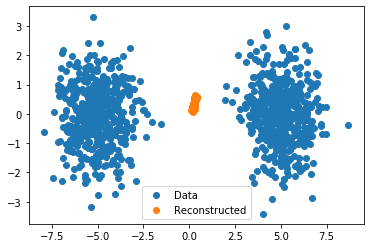

 10%|▉         | 99/1000 [00:07<01:09, 13.04it/s]

Current epoch: 101 	 Current ELBO: -4.458617687225342
Mean abs mu0: 0.31295502
Mean sigma 1.0174782
Max sigma 1.1228542
Min sigma 0.9778788


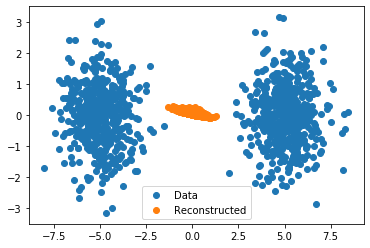

 20%|█▉        | 199/1000 [00:14<00:58, 13.59it/s]

Current epoch: 201 	 Current ELBO: -4.4681854248046875
Mean abs mu0: 0.17943665
Mean sigma 1.0096264
Max sigma 1.1259804
Min sigma 0.97143435


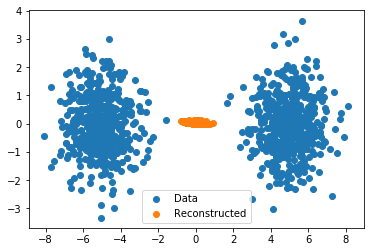

 30%|██▉       | 299/1000 [00:22<00:51, 13.56it/s]

Current epoch: 301 	 Current ELBO: -4.49619197845459
Mean abs mu0: 0.10421744
Mean sigma 1.0075821
Max sigma 1.1026385
Min sigma 0.9594872


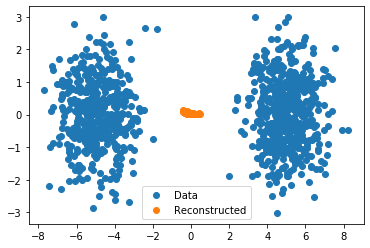

 40%|███▉      | 399/1000 [00:30<00:44, 13.43it/s]

Current epoch: 401 	 Current ELBO: -4.493871212005615
Mean abs mu0: 0.046021037
Mean sigma 1.0029873
Max sigma 1.045572
Min sigma 0.96537423


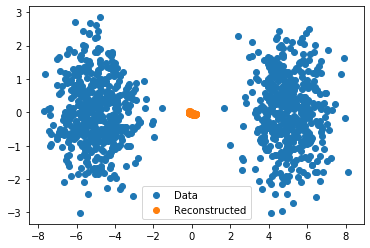

 50%|████▉     | 499/1000 [00:37<00:36, 13.54it/s]

Current epoch: 501 	 Current ELBO: -4.479707717895508
Mean abs mu0: 0.055551015
Mean sigma 1.0239702
Max sigma 1.0335815
Min sigma 1.0149403


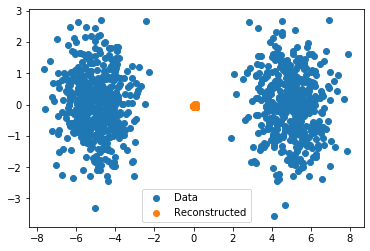

 60%|█████▉    | 599/1000 [00:45<00:30, 13.14it/s]

Current epoch: 601 	 Current ELBO: -4.469045162200928
Mean abs mu0: 0.016053155
Mean sigma 0.99901175
Max sigma 1.0263269
Min sigma 0.9762846


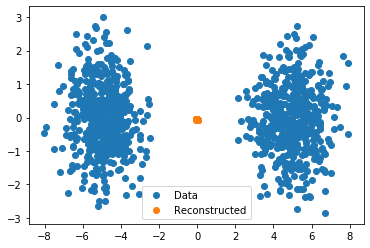

 70%|██████▉   | 699/1000 [00:52<00:21, 13.74it/s]

Current epoch: 701 	 Current ELBO: -4.476635456085205
Mean abs mu0: 0.023313573
Mean sigma 0.9890536
Max sigma 1.0034783
Min sigma 0.97472584


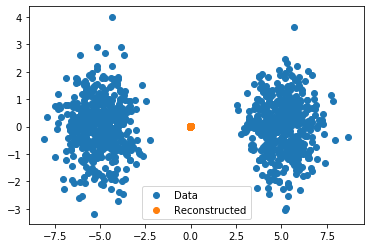

 80%|███████▉  | 799/1000 [01:00<00:14, 13.71it/s]

Current epoch: 801 	 Current ELBO: -4.46683406829834
Mean abs mu0: 0.013238293
Mean sigma 0.9998257
Max sigma 1.0057214
Min sigma 0.9936552


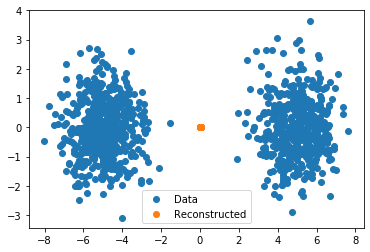

 90%|████████▉ | 899/1000 [01:07<00:07, 13.67it/s]

Current epoch: 901 	 Current ELBO: -4.505162715911865
Mean abs mu0: 0.034840956
Mean sigma 1.0022743
Max sigma 1.0050421
Min sigma 0.9999929


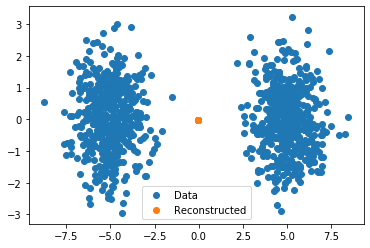

100%|██████████| 1000/1000 [01:15<00:00, 13.30it/s]


In [7]:
print_info_ = 100

# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        plt.close()
        optimizer.zero_grad()

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        
        mu_dec, sigma_dec = target.decoder(z)
        if args.data == 'toy_data':
            log_numenator = torch.distributions.Normal(loc=mu_dec, scale=sigma_dec).log_prob(batch_train).sum(1) + args.std_normal.log_prob(z).sum(1)
        else:
            log_numenator = torch.distributions.Bernoulli(logits=mu_dec).log_prob(batch_train).sum([1, 2, 3]) + args.std_normal.log_prob(z).sum(1)
        log_denumenator = -torch.sum(torch.log(sigma), 1) + args.std_normal.log_prob(u).sum(1)
        elbo = torch.mean(log_numenator - log_denumenator)
        (-elbo).backward()

        optimizer.step()
        optimizer.zero_grad()
    if ep % print_info_ == 0:
        if args.data == 'toy_data':
            print('Current epoch:', (ep + 1), '\t', 'Current ELBO:', elbo.detach().mean().item())
            print('Mean abs mu0:', torch.mean(torch.abs(mu_dec[:, 0])).cpu().detach().numpy())
            print('Mean sigma', torch.mean(sigma).cpu().detach().numpy())
            print('Max sigma', torch.max(sigma).cpu().detach().numpy())
            print('Min sigma', torch.min(sigma).cpu().detach().numpy())
            plt.scatter(batch_train.cpu().detach().numpy()[:, 0], batch_train.cpu().detach().numpy()[:, 1], label='Data')
            plt.scatter(mu_dec.cpu().detach().numpy()[:, 0], mu_dec.cpu().detach().numpy()[:, 1], label='Reconstructed')
            plt.legend()
            plt.show()
        else:
            plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)